In [1]:
import tensorflow as tf
import pandas as pd
import re
import string
import numpy as np
import nltk
import spacy
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import sys
from spacy.lang.en import English
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer

In [2]:
df=pd.read_json(r"D:\data science\Sarcasm_Headlines_Dataset.json",lines=True)
df=df[['headline','is_sarcastic']]
df.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


In [3]:
df.is_sarcastic.isnull().any()
df.headline.isnull().any()

False

In [4]:
df['headline']=df.headline.apply(lambda x:x.lower())
df['headline']=df.headline.apply(lambda x: ' '.join(word.strip(string.punctuation) for word in x.split()))

In [5]:
df['headline_count']=df.headline.apply(lambda x:len(list(x.split())))
df['headline_unique_word_count']=df.headline.apply(lambda x:len(set(x.split())))
df['headline_has_digits']=df.headline.apply(lambda x: bool(re.search(r'\d',x)))
df

,headline,is_sarcastic,headline_count,headline_unique_word_count,headline_has_digits
0,former versace store clerk sues over secret bl...,0,12,12,False
1,the roseanne revival catches up to our thorny ...,0,14,14,False
2,mom starting to fear son's web series closest ...,1,14,13,False
3,boehner just wants wife to listen not come up ...,1,13,13,False
4,j.k rowling wishes snape happy birthday in the...,0,11,11,False
...,...,...,...,...,...
26704,american politics in moral free-fall,0,5,5,False
26705,america's best 20 hikes,0,4,4,True
26706,reparations and obama,0,3,3,False
26707,israeli ban targeting boycott supporters raise...,0,8,8,False


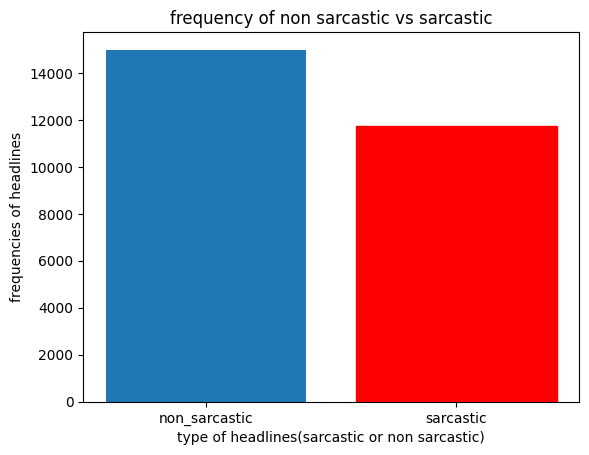

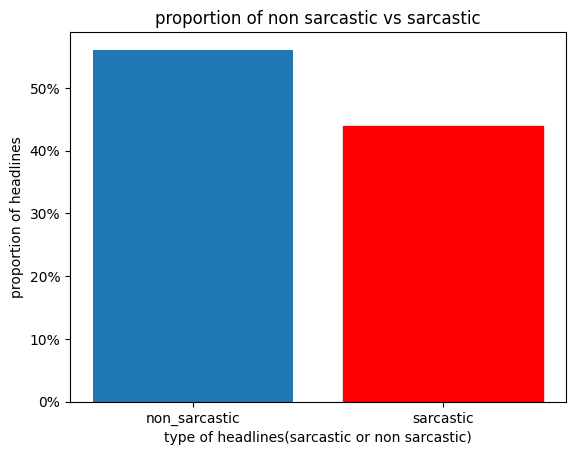

In [6]:
sarcastic_dat=df.groupby('is_sarcastic').count()
sarcastic_dat.index=['non_sarcastic','sarcastic']
plt.xlabel('type of headlines(sarcastic or non sarcastic)')
plt.ylabel('frequencies of headlines')
plt.xticks(fontsize=10)
plt.title('frequency of non sarcastic vs sarcastic')
bar_graph=plt.bar(sarcastic_dat.index,sarcastic_dat.headline_count)
bar_graph[1].set_color('r')
plt.show()



plt.xlabel('type of headlines(sarcastic or non sarcastic)')
plt.ylabel('proportion of headlines')
plt.xticks(fontsize=10)
plt.title('proportion of non sarcastic vs sarcastic')
bar_graph=plt.bar(sarcastic_dat.index,sarcastic_dat.headline_count/sarcastic_dat.headline_count.sum())
bar_graph[1].set_color('r')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

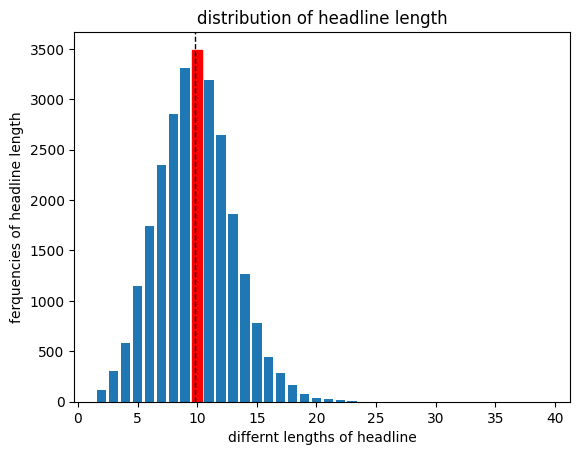

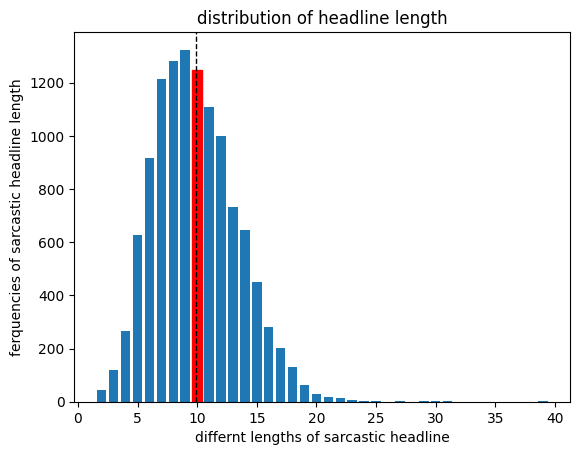

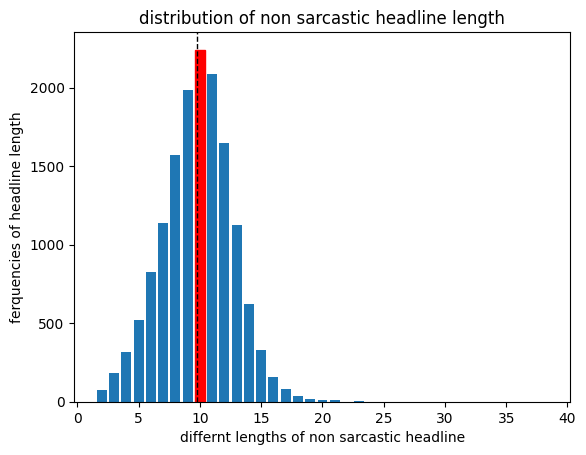

In [7]:
all_data=df.groupby('headline_count').count()
sarcastic_dat1=df[df.is_sarcastic==1]
sarcastic_data=sarcastic_dat1.groupby('headline_count').count()
non_sarcastic_dat1=df[df.is_sarcastic==0]
non_sarcastic_data=non_sarcastic_dat1.groupby('headline_count').count()


plt.xlabel('differnt lengths of headline')
plt.ylabel('ferquencies of headline length')
plt.xticks(fontsize=10)
plt.title('distribution of headline length')
bar_graph=plt.bar(all_data.index,all_data.headline)
bar_graph[8].set_color('r')
plt.axvline(df.headline_count.mean(),color='k',linestyle='dashed',linewidth=1)
plt.show()


plt.xlabel('differnt lengths of sarcastic headline')
plt.ylabel('ferquencies of sarcastic headline length')
plt.xticks(fontsize=10)
plt.title('distribution of headline length')
bar_graph=plt.bar(sarcastic_data.index,sarcastic_data.headline)
bar_graph[8].set_color('r')
plt.axvline(sarcastic_dat1.headline_count.mean(),color='k',linestyle='dashed',linewidth=1)
plt.show()


plt.xlabel('differnt lengths of non sarcastic headline')
plt.ylabel('ferquencies of headline length')
plt.xticks(fontsize=10)
plt.title('distribution of non sarcastic headline length')
bar_graph=plt.bar(non_sarcastic_data.index,non_sarcastic_data.headline)
bar_graph[8].set_color('r')
plt.axvline(non_sarcastic_dat1.headline_count.mean(),color='k',linestyle='dashed',linewidth=1)
plt.show()

In [8]:
parser=English()
en_stop=set(nltk.corpus.stopwords.words('english'))

def tokenize(text):
    lda_tokens=[]
    tokens=parser(text)
    for  token in tokens:
        if token.orth_.isspace():
            continue
        elif token.like_url:
            lda_tokens.append('URL')
        elif token.orth_.startswith('@'):
            lda_tokens.append('SCREEN_NAME')
        else:
            lda_tokens.append(token.lower_)
    return lda_tokens


def get_lemma(word):
    lemma=wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma
    
def prepare_text_for_lda(text):
    tokens=tokenize(text)
    tokens=[token for token in tokens if len(token)>4]
    tokens=[token for token in tokens if token not in en_stop]
    tokens=[get_lemma(token) for token in tokens]
    return tokens

In [9]:
text_data=[]
for headline in df.headline:
    tokens=prepare_text_for_lda(headline)
    text_data.append(tokens)

In [10]:
from gensim import corpora
import pickle

dictionary=corpora.Dictionary(text_data)
corpus=[dictionary.doc2bow(text) for text in text_data]
pickle.dump(corpus,open('corpus.pkl','wb'))
dictionary.save('dictionary.gensim')

In [11]:
import gensim


NUM_TOPICS=[3,4,5]
ldamodel=gensim.models.ldamodel.LdaModel(corpus,num_topics=NUM_TOPICS[1],id2word=dictionary,passes=15)
ldamodel.save('model5.gensim')
topics=ldamodel.print_topics(num_words=5)
topics

[(0,
  '0.007*"world" + 0.006*"america" + 0.005*"woman" + 0.005*"take" + 0.004*"first"'),
 (1,
  '0.011*"woman" + 0.006*"family" + 0.005*"report" + 0.004*"child" + 0.004*"movie"'),
 (2,
  '0.039*"trump" + 0.012*"donald" + 0.010*"people" + 0.007*"clinton" + 0.007*"change"'),
 (3,
  '0.005*"court" + 0.004*"police" + 0.004*"school" + 0.004*"kill" + 0.004*"supreme"')]

In [12]:
ldamodel=gensim.models.ldamodel.LdaModel(corpus,num_topics=3,id2word=dictionary,passes=15)
ldamodel.save('model3.gensim')
topics=ldamodel.print_topics(num_words=5)
topics

[(0,
  '0.031*"trump" + 0.009*"donald" + 0.008*"woman" + 0.008*"first" + 0.006*"clinton"'),
 (1,
  '0.010*"american" + 0.009*"report" + 0.008*"house" + 0.006*"white" + 0.005*"obama"'),
 (2,
  '0.005*"school" + 0.005*"woman" + 0.005*"friend" + 0.005*"still" + 0.004*"report"')]

In [13]:
ldamodel=gensim.models.ldamodel.LdaModel(corpus,num_topics=10,id2word=dictionary,passes=15)
ldamodel.save('model10.gensim')
topics=ldamodel.print_topics(num_words=5)
topics

[(0,
  '0.012*"story" + 0.012*"woman" + 0.010*"congress" + 0.010*"finally" + 0.010*"black"'),
 (1,
  '0.016*"family" + 0.015*"school" + 0.015*"woman" + 0.010*"month" + 0.009*"friend"'),
 (2,
  '0.022*"obama" + 0.022*"clinton" + 0.021*"state" + 0.019*"trump" + 0.012*"election"'),
 (3,
  '0.013*"child" + 0.013*"really" + 0.011*"report" + 0.011*"want" + 0.010*"thing"'),
 (4,
  '0.016*"trump" + 0.016*"court" + 0.011*"supreme" + 0.011*"season" + 0.010*"never"'),
 (5,
  '0.033*"report" + 0.020*"right" + 0.017*"american" + 0.015*"study" + 0.013*"find"'),
 (6,
  '0.066*"trump" + 0.033*"donald" + 0.013*"america" + 0.012*"release" + 0.009*"death"'),
 (7,
  '0.018*"trump" + 0.015*"would" + 0.010*"country" + 0.009*"question" + 0.008*"email"'),
 (8,
  '0.028*"house" + 0.026*"world" + 0.023*"white" + 0.015*"things" + 0.012*"parent"'),
 (9,
  '0.023*"change" + 0.017*"police" + 0.011*"climate" + 0.010*"college" + 0.010*"kill"')]

In [26]:
train_data,test_data=train_test_split(df[['headline','is_sarcastic']],test_size=0.1)

training_sentences=list(train_data['headline'])
training_labels=list(train_data['is_sarcastic'])


testing_sentences=list(test_data['headline'])
testing_labels=list(test_data['is_sarcastic'])

training_labels_final=np.array(training_labels)
testing_labels_final=np.array(testing_labels)

In [33]:
vocab_size=10000
embedding_dim=16
max_length=120
trunc_type='post'
oov_tok="<OOV>"

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer=Tokenizer(num_words=vocab_size,oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index=tokenizer.word_index
sequences=tokenizer.texts_to_sequences(training_sentences)
padded=pad_sequences(sequences,maxlen=max_length,truncating=trunc_type)

testing_sequences=tokenizer.texts_to_sequences(testing_sentences)
testing_padded=pad_sequences(testing_sequences,maxlen=max_length)

In [34]:
model=tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(100,kernel_regularizer=tf.keras.regularizers.l1(0.003),activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1,kernel_regularizer=tf.keras.regularizers.l1(0.003),activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 16)           160000    
                                                                 
 bidirectional (Bidirectiona  (None, 64)               9600      
 l)                                                              
                                                                 
 dense (Dense)               (None, 100)               6500      
                                                                 
 batch_normalization (BatchN  (None, 100)              400       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

In [37]:
num_epochs=10
history = model.fit(padded, training_labels_final, validation_data=(testing_padded, testing_labels_final), epochs=10, batch_size=64)

Epoch 1/10
376/376 [==============================] - 64s 132ms/step - loss: 0.8548 - accuracy: 0.7810 - val_loss: 0.5475 - val_accuracy: 0.7424
Epoch 2/10
376/376 [==============================] - 47s 124ms/step - loss: 0.2936 - accuracy: 0.8988 - val_loss: 0.4098 - val_accuracy: 0.8360
Epoch 3/10
376/376 [==============================] - 47s 124ms/step - loss: 0.2088 - accuracy: 0.9349 - val_loss: 0.4445 - val_accuracy: 0.8424
Epoch 4/10
376/376 [==============================] - 47s 124ms/step - loss: 0.1536 - accuracy: 0.9591 - val_loss: 0.4598 - val_accuracy: 0.8341
Epoch 5/10
376/376 [==============================] - 47s 124ms/step - loss: 0.1157 - accuracy: 0.9730 - val_loss: 0.5608 - val_accuracy: 0.8323
Epoch 6/10
376/376 [==============================] - 47s 124ms/step - loss: 0.0859 - accuracy: 0.9837 - val_loss: 0.6514 - val_accuracy: 0.8282
Epoch 7/10
376/376 [==============================] - 47s 124ms/step - loss: 0.0658 - accuracy: 0.9899 - val_loss: 0.7520 - val_ac

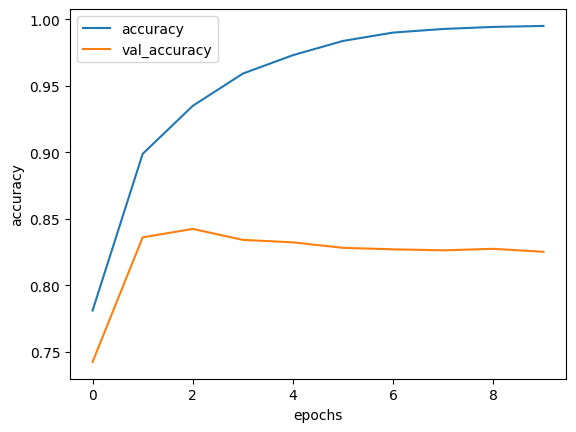

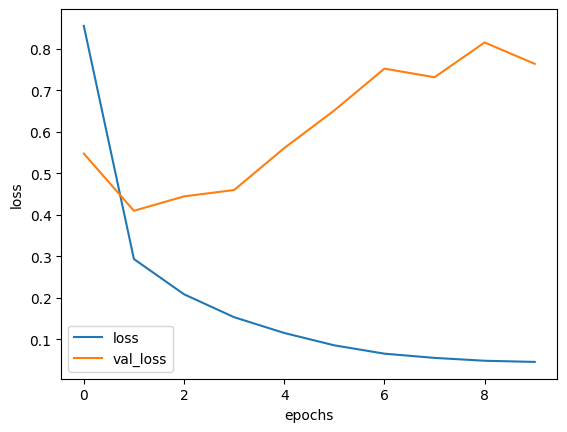

In [39]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel('epochs')
    plt.ylabel(string)
    plt.legend([string,'val_'+string])
    plt.show()
    
plot_graphs(history,'accuracy')
plot_graphs(history,'loss')
plt.show()

In [40]:
model=tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(100,kernel_regularizer=tf.keras.regularizers.l2(0.003),activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1,kernel_regularizer=tf.keras.regularizers.l2(0.003),activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 120, 16)           160000    
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               9600      
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 100)               6500      
                                                                 
 batch_normalization_1 (Batc  (None, 100)              400       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                

In [41]:
num_epochs=10
history = model.fit(padded, training_labels_final, validation_data=(testing_padded, testing_labels_final), epochs=10, batch_size=64)

Epoch 1/10
376/376 [==============================] - 64s 132ms/step - loss: 0.5270 - accuracy: 0.7761 - val_loss: 1.2090 - val_accuracy: 0.5668
Epoch 2/10
376/376 [==============================] - 48s 127ms/step - loss: 0.2670 - accuracy: 0.8969 - val_loss: 0.3506 - val_accuracy: 0.8536
Epoch 3/10
376/376 [==============================] - 48s 127ms/step - loss: 0.1819 - accuracy: 0.9317 - val_loss: 0.4716 - val_accuracy: 0.8151
Epoch 4/10
376/376 [==============================] - 47s 124ms/step - loss: 0.1270 - accuracy: 0.9568 - val_loss: 0.5010 - val_accuracy: 0.8349
Epoch 5/10
376/376 [==============================] - 47s 125ms/step - loss: 0.0942 - accuracy: 0.9693 - val_loss: 0.8727 - val_accuracy: 0.7817
Epoch 6/10
376/376 [==============================] - 44s 118ms/step - loss: 0.0697 - accuracy: 0.9793 - val_loss: 0.7197 - val_accuracy: 0.8285
Epoch 7/10
376/376 [==============================] - 46s 123ms/step - loss: 0.0481 - accuracy: 0.9865 - val_loss: 0.7363 - val_ac

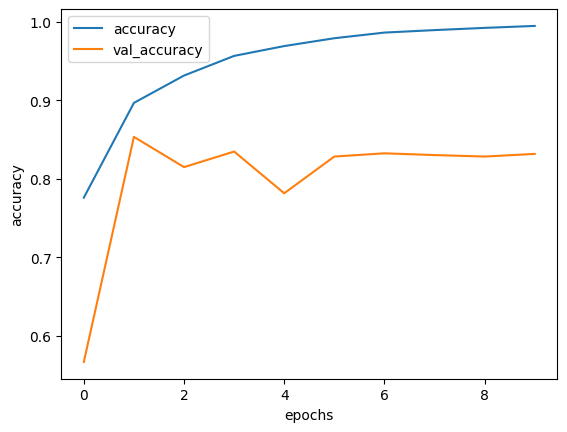

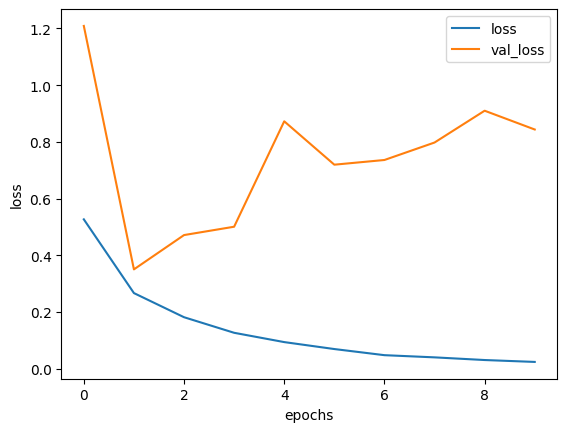

In [42]:
plot_graphs(history,'accuracy')
plot_graphs(history,'loss')
plt.show()